# Causal Impact

## Import libraries

In [1]:
#!pip install matplotlib pycausalimpact seaborn statsmodels scipy scikit-learn

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_process import ArmaProcess
from causalimpact import CausalImpact
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import statsmodels.api as sm
from scipy.stats import ttest_1samp
from itertools import combinations
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

In [3]:
from clickhouse_driver import Client


user_name = 'user_name'
pwd = 'password'

# creating connection ClickHouse
client = Client(host='clickhouse.lab.karpov.courses', port=9000,
                user=user_name, password=pwd, database='hardda')

# checking connection
result = client.execute("SELECT * FROM hardda.user_dm_events LIMIT 1")

# showing the result
for row in result[0:1]:
    print(row)

(datetime.date(2022, 2, 1), datetime.date(2022, 1, 31), 'android', 'f7411212fd0e2523e126cbfdd3f226c211212', '4beb10e1-aeeb-4c52-acd2-ce1ddbc1fc24b10e1', 22, 11, 3, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0)


## Tasks

### Task 1.

 **Write an SQL query to get `event_date`, `platform`, `cnt_add_to_favorites`, `cnt_view_advertisement`, `cnt_display_phone`, `cr` from `user_dm_events` between 2022-02-01 and 2022-07-15.**

In [4]:
query = '''
SELECT
  event_date,
  platform,
  SUM(cnt_add_to_favorites) AS cnt_fav,
  SUM(cnt_view_advertisement) AS cnt_view,
  SUM(cnt_display_phone) AS cnt_display_phone
FROM
  user_dm_events
WHERE
  event_date BETWEEN '2022-02-01' and '2022-07-15'
GROUP BY
  event_date,
  platform
'''

In [5]:
result = client.execute(query)

In [6]:
len(result)

330

In [7]:
df = pd.DataFrame(result, columns=['event_date', 'platform',
                                   'cnt_fav', 'cnt_view', 'cnt_display_phone'])

df

,event_date,platform,cnt_fav,cnt_view,cnt_display_phone
0,2022-06-02,android,42920,1475717,34164
1,2022-06-28,ios,19621,516822,12483
2,2022-04-18,ios,22804,633205,14099
3,2022-02-19,ios,17286,507738,11343
4,2022-03-30,android,50196,1775406,43112
...,...,...,...,...,...
325,2022-03-27,android,55435,1992935,44901
326,2022-04-23,ios,20434,582899,12763
327,2022-06-23,ios,18700,488290,12370
328,2022-02-16,ios,18000,538275,12695


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   event_date         330 non-null    object
 1   platform           330 non-null    object
 2   cnt_fav            330 non-null    int64 
 3   cnt_view           330 non-null    int64 
 4   cnt_display_phone  330 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 13.0+ KB


In [9]:
df['event_date'] = pd.to_datetime(df['event_date'], format='%Y-%m-%d')

In [10]:
df['cr'] = df['cnt_fav'] / df['cnt_view']
df = df.sort_values(['event_date', 'platform'])
df.reset_index(drop=True, inplace=True)

In [11]:
df

,event_date,platform,cnt_fav,cnt_view,cnt_display_phone,cr
0,2022-02-01,android,49821,1946760,41451,0.025592
1,2022-02-01,ios,18210,560769,12221,0.032473
2,2022-02-02,android,49712,1936104,41069,0.025676
3,2022-02-02,ios,18113,558109,12456,0.032454
4,2022-02-03,android,49597,1890293,41462,0.026238
...,...,...,...,...,...,...
325,2022-07-13,ios,20192,530259,12482,0.038080
326,2022-07-14,android,42352,1450645,35916,0.029195
327,2022-07-14,ios,20307,526506,13108,0.038569
328,2022-07-15,android,39781,1374144,32537,0.028950


### Task 2.  

**Build a graph of the dynamics of the `cr` metric by platform.** 

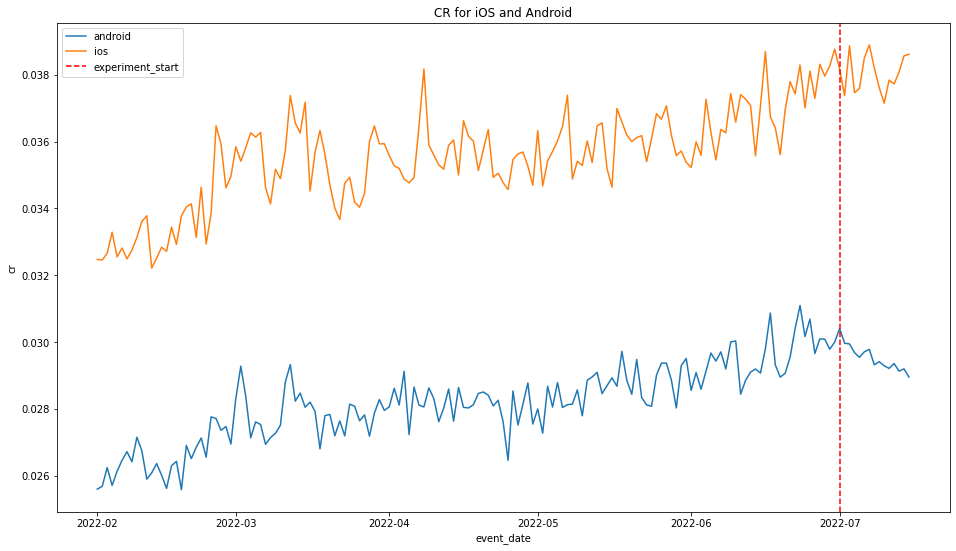

In [12]:
plt.figure(figsize=(16,9))

sns.lineplot(df, x='event_date', y='cr', hue='platform')
plt.axvline(pd.to_datetime('2022-07-01', format='%Y-%m-%d'), color='red', linestyle='dashed', label='experiment_start')
plt.legend()
plt.title('CR for iOS and Android');

### Task 3. 

**Specify the average conversion rate for the target metric in the IOS platform ('cr_ios') by days before the update (less than '2022-07-01').** 

In [13]:
exp_data = pd.to_datetime('2022-07-01', format='%Y-%m-%d')

In [14]:
df[(df['platform'] == 'ios') & (df['event_date'] < exp_data)].cr.mean()

0.035519276129212636

### Task 4. 

**Specify the average conversion rate for the target metric in the IOS platform ('cr_ios') by days after the update (>= '2022-07-01').**

In [15]:
df[(df['platform'] == 'ios') & (df['event_date'] >= exp_data)].cr.mean()

0.03804823394818289

### Task 5. 

**Build a correlation matrix using pre-data.**

In [16]:
df_pivot = df.pivot(index='event_date', values=['cnt_fav', 'cnt_view', 'cnt_display_phone', 'cr'],
                    columns='platform')

In [17]:
df_pivot.columns = df_pivot.columns.droplevel(0)

In [18]:
df_pivot.columns = ['cnt_fav_android', 'cnt_fav_ios',
                    'cnt_view_android', 'cnt_view_ios',
                    'cnt_display_phone_android', 'cnt_display_phone_ios',
                    'cr_android', 'cr_ios']

In [19]:
df_pivot.reset_index(inplace=True)

In [20]:
df_pivot

,event_date,cnt_fav_android,cnt_fav_ios,cnt_view_android,cnt_view_ios,cnt_display_phone_android,cnt_display_phone_ios,cr_android,cr_ios
0,2022-02-01,49821.0,18210.0,1946760.0,560769.0,41451.0,12221.0,0.025592,0.032473
1,2022-02-02,49712.0,18113.0,1936104.0,558109.0,41069.0,12456.0,0.025676,0.032454
2,2022-02-03,49597.0,18001.0,1890293.0,551167.0,41462.0,11644.0,0.026238,0.032660
3,2022-02-04,46528.0,16983.0,1810075.0,510172.0,40558.0,11052.0,0.025705,0.033289
4,2022-02-05,46816.0,16678.0,1792061.0,512377.0,39227.0,11102.0,0.026124,0.032550
...,...,...,...,...,...,...,...,...,...
160,2022-07-11,44210.0,21198.0,1513556.0,560109.0,35550.0,13221.0,0.029209,0.037846
161,2022-07-12,45374.0,20798.0,1545732.0,551235.0,37343.0,12940.0,0.029354,0.037730
162,2022-07-13,43521.0,20192.0,1494189.0,530259.0,37193.0,12482.0,0.029127,0.038080
163,2022-07-14,42352.0,20307.0,1450645.0,526506.0,35916.0,13108.0,0.029195,0.038569


In [21]:
pre_data_pivot = df_pivot[df_pivot['event_date'] < exp_data]

In [22]:
pre_data_pivot[['cnt_fav_android', 'cnt_view_android', 'cnt_display_phone_android', 'cr_android',
                'cnt_fav_ios', 'cnt_view_ios', 'cnt_display_phone_ios', 'cr_ios']] \
    .corr().style.background_gradient(cmap='coolwarm', axis=None)

,cnt_fav_android,cnt_view_android,cnt_display_phone_android,cr_android,cnt_fav_ios,cnt_view_ios,cnt_display_phone_ios,cr_ios
cnt_fav_android,1.000000,0.954738,0.927072,-0.463981,0.719666,0.876254,0.779614,-0.454857
cnt_view_android,0.954738,1.000000,0.913476,-0.704531,0.580466,0.822030,0.660397,-0.635744
cnt_display_phone_android,0.927072,0.913476,1.000000,-0.519268,0.609166,0.746078,0.800585,-0.400352
cr_android,-0.463981,-0.704531,-0.519268,1.000000,-0.029146,-0.368949,-0.123136,0.800127
cnt_fav_ios,0.719666,0.580466,0.609166,-0.029146,1.000000,0.903452,0.832568,0.103473
cnt_view_ios,0.876254,0.822030,0.746078,-0.368949,0.903452,1.000000,0.794786,-0.331868
cnt_display_phone_ios,0.779614,0.660397,0.800585,-0.123136,0.832568,0.794786,1.000000,-0.016359
cr_ios,-0.454857,-0.635744,-0.400352,0.800127,0.103473,-0.331868,-0.016359,1.000000


### Task 6. 

**Conduct casual impact analysis for `cr_ios` using three the most correlated regressors from the previous step.**

In [23]:
ts_data = df_pivot[['event_date', 'cr_ios', 'cr_android', 'cnt_view_android', 'cnt_fav_android']]

In [24]:
ts_data.set_index('event_date', inplace=True)

In [25]:
ts_data.rename_axis(None, inplace=True)

In [26]:
ts_data

,cr_ios,cr_android,cnt_view_android,cnt_fav_android
2022-02-01,0.032473,0.025592,1946760.0,49821.0
2022-02-02,0.032454,0.025676,1936104.0,49712.0
2022-02-03,0.032660,0.026238,1890293.0,49597.0
2022-02-04,0.033289,0.025705,1810075.0,46528.0
2022-02-05,0.032550,0.026124,1792061.0,46816.0
...,...,...,...,...
2022-07-11,0.037846,0.029209,1513556.0,44210.0
2022-07-12,0.037730,0.029354,1545732.0,45374.0
2022-07-13,0.038080,0.029127,1494189.0,43521.0
2022-07-14,0.038569,0.029195,1450645.0,42352.0


In [27]:
ts_pre_period = [pd.to_datetime(date) for date in ['2022-02-01', '2022-06-30']]
ts_post_period = [pd.to_datetime(date) for date in ['2022-07-01', '2022-07-15']]

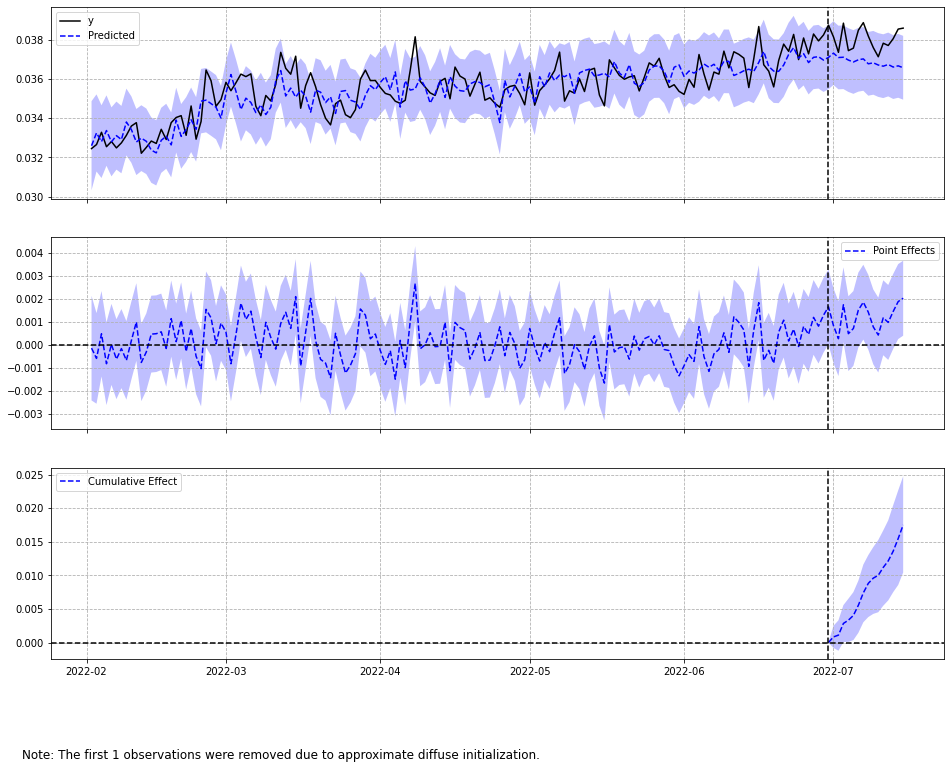

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.04               0.57
Prediction (s.d.)         0.04 (0.0)         0.55 (0.0)
95% CI                    [0.04, 0.04]       [0.55, 0.56]

Absolute effect (s.d.)    0.0 (0.0)          0.02 (0.0)
95% CI                    [0.0, 0.0]         [0.01, 0.02]

Relative effect (s.d.)    3.17% (0.66%)      3.17% (0.66%)
95% CI                    [1.89%, 4.48%]     [1.89%, 4.48%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [28]:
ci = CausalImpact(ts_data, ts_pre_period, ts_post_period, alpha = 0.05)
ci.plot(figsize = (16, 12))
print(ci.summary())

### Task 7. 

**Analyze covariates statistical significance.**

In [29]:
ci.trained_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                 cr_ios   No. Observations:                  150
Model:                    local level   Log Likelihood                -131.619
Date:                Sun, 03 Dec 2023   AIC                            273.239
Time:                        10:28:11   BIC                            288.258
Sample:                    02-01-2022   HQIC                           279.341
                         - 06-30-2022                                         
Covariance Type:                  opg                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
sigma2.irregular          0.3265      0.043      7.519      0.000       0.241       0.412
sigma2.level              0.0001      0.000      0.376      0.707      -0.001       0.001
beta.cr_android          -0.5684      0.484     -1.173      0.241      -1.518       0.381
beta.cnt_view_android    -3.9016      1.441     -2.707      0.007      -6.726      -1.077
beta.cnt_fav_android      3.0116      1.168      2.579      0.010       0.723       5.300
===================================================================================
Ljung-Box (L1) (Q):                   4.51   Jarque-Bera (JB):                 2.78
Prob(Q):                              0.03   Prob(JB):                         0.25
Heteroskedasticity (H):               0.84   Skew:                             0.31
Prob(H) (two-sided):                  0.53   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Task 8. 

**Analyze residuals properties.**

p-value Dickey-Fuller test = 0.000000
p-value t-test = 0.121894
p-value Ljung-Box test = 0.033779


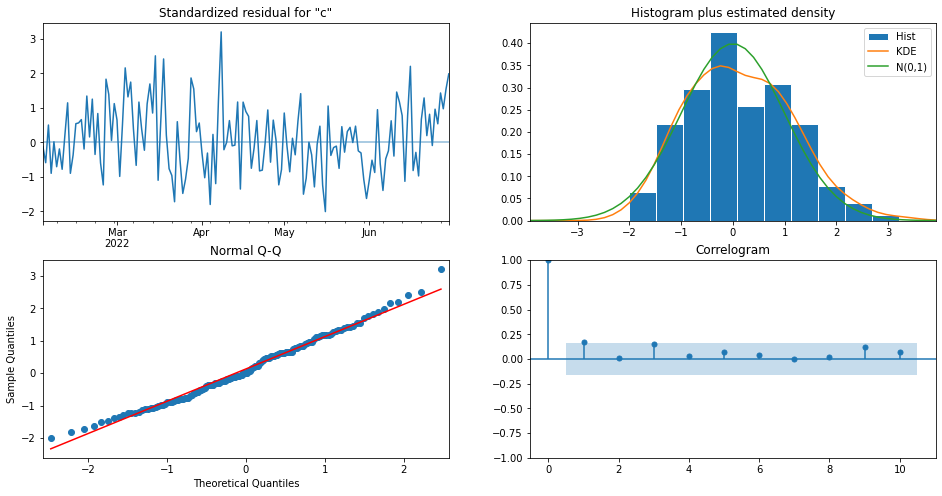

In [30]:
# давайте отпринтуем результаты проверки остатков модели
print("p-value Dickey-Fuller test = %f" % sm.tsa.stattools.adfuller(ci.trained_model.resid)[1])
print("p-value t-test = %f" % ttest_1samp(ci.trained_model.resid, 0)[1])
print("p-value Ljung-Box test = %f" % ci.trained_model.test_serial_correlation('ljungbox')[0, :, 0][1])
ci.trained_model.plot_diagnostics(figsize = (16, 8));

In [31]:
alpha = 0.05

if sm.tsa.stattools.adfuller(ci.trained_model.resid)[1] < alpha:
    print('The time series is likely stationary.')
else:
    print('We are not able to reject H0, the time series is likely non-sationary.')

The time series is likely stationary.


In [32]:
alpha = 0.05

if ttest_1samp(ci.trained_model.resid, 0)[1] < alpha:
    print('There is a shift in residuals distribution.')
else:
    print('We are not able to reject H0, there is no shift in residuals distribution.')

We are not able to reject H0, there is no shift in residuals distribution.


In [33]:
alpha = 0.05

if ci.trained_model.test_serial_correlation('ljungbox')[0, :, 0][1] < alpha:
    print('Reject the null hypothesis; there is significant autocorrelation.')
else:
    print('Fail to reject the null hypothesis; there is no significant autocorrelation.')

Reject the null hypothesis; there is significant autocorrelation.


### Task 9. 

**Evaluate model's performance on historical data.**

In [34]:
ci_data = ci.data.merge(ci.inferences, left_index = True, right_index = True)
ci_data_pre = ci_data.loc[ts_pre_period[0]:ts_pre_period[-1], :]

mae = mean_absolute_error(ci_data_pre.cr_ios, ci_data_pre.preds)
mape = mean_absolute_percentage_error(ci_data_pre.cr_ios, ci_data_pre.preds)
r2 = r2_score(ci_data_pre.cr_ios, ci_data_pre.preds)

print('MAE =', round(mae, 3))
print('MAPE =', round(mape, 3))
print('R2_score =', r2)

MAE = 0.001
MAPE = 0.019
R2_score = 0.6631218763743272


### Task 10. 

**Let's try to evaluate statistical power of Causal Impact approach with help of simulations.**

In [35]:
import joblib
import warnings


def causal_analysis(data, target_value, covariate, n_days = 14, control_percent = 0.6, sample_n = 30):
    '''
    data - historical data on which we evaluate the covariate
    covariate - name of the covariate column
    n_days - period in days for the post period
    control_percent - fraction of the dataset reserved for the pre period
    sample_n - number of simulations
    '''
    
    n_days -= 1

    data = pd.concat([data.loc[:, [target_value]], data.loc[:, covariate]], axis = 1)

    df_copy = data.copy()
    effects = [0.9, 0.95, 0.975, 1., 1.025, 1.05, 1.1] # effects size to check
    rel_effects = []

    dates = pd.DataFrame({'post_period_0': data.index}) # dates

    # control group
    initial = dates.values[0][0]
    # test group based on random dates
    test = dates.iloc[int(len(dates)*(control_percent)):-n_days]\
                .sample(sample_n, random_state = 123, replace = True)\
    # defining pre and post periods
    test['post_period_1'] = test.post_period_0 + pd.DateOffset(days = n_days)
    test['pre_period_0'] = initial
    test['pre_period_1'] = test.post_period_0 - pd.DateOffset(days = 1)

    test = test.astype(str)
    a = np.empty((sample_n, len(effects) + 2))

    def calculate_sse_mape_pval(d):
        sse = []
        mape = []
        p_vals = []
        for i in range(len(effects)):
                
            warnings.simplefilter('ignore')
            
            pre_period = [test.pre_period_0.values[d], test.pre_period_1.values[d]]
            post_period = [test.post_period_0.values[d], test.post_period_1.values[d]]

            df_copy = data.copy()

            df_copy.loc[np.logical_and(
                        df_copy.index >= post_period[0], df_copy.index <= post_period[1]), target_value] *= effects[i] # adding effect
            ci = CausalImpact(df_copy, pre_period, post_period)

            relative_eff = ci.summary_data.loc['rel_effect', :][0].round(3)
            real_eff = effects[i] - 1
            to_sse = pow(relative_eff - real_eff, 2)
            to_mape = abs(relative_eff - real_eff) * 100

            sse.append(to_sse)
            mape.append(to_mape)
            rel_effects.append(relative_eff)
            p_vals.append(ci.p_value)
        return (d, sum(sse), np.mean(mape), p_vals[effects.index(1)], p_vals[effects.index(1.025)],
               p_vals[effects.index(0.975)], p_vals[effects.index(1.05)], p_vals[effects.index(0.95)],
               p_vals[effects.index(1.1)], p_vals[effects.index(0.9)])

    results = joblib.Parallel(n_jobs=-1, verbose = len(test))(joblib.delayed(calculate_sse_mape_pval)(d) for d in range(len(test)))

    for result in results:
        d = result[0]
        a[d][0] = result[1]
        a[d][1] = result[2]
        a[d][2] = result[3]
        a[d][3] = result[4]
        a[d][4] = result[5]
        a[d][5] = result[6]
        a[d][6] = result[7]
        a[d][7] = result[8]
        a[d][8] = result[9]

    aa = pd.DataFrame(a, columns = ['sse', 'mape', 'p_val_1', 'p_val_1_025', 'p_val_0_975',
                                    'p_val_1_05', 'p_val_0_95', 'p_val_1_1', 'p_val_0_9'])
    final = test.reset_index().merge(aa.reset_index(), left_index = True, right_index = True)
    final.drop(columns = ['index_x', 'index_y'], inplace = True)
    final['covariate'] = ', '.join(covariate)
    return final

In [36]:
column_combinations = []
for i in range(1, len(ts_data.columns[1:]) + 1):
    column_combinations.extend(list(combinations(ts_data.columns[1:], i)))
column_combinations

[('cr_android',),
 ('cnt_view_android',),
 ('cnt_fav_android',),
 ('cr_android', 'cnt_view_android'),
 ('cr_android', 'cnt_fav_android'),
 ('cnt_view_android', 'cnt_fav_android'),
 ('cr_android', 'cnt_view_android', 'cnt_fav_android')]

In [37]:
%%time
n_days = 14
control_pct = 0.6
n_sim = 30
res = pd.DataFrame()

np.random.seed(1)
for comb in column_combinations:
    caus = causal_analysis(ts_data, 'cr_ios', comb, n_days, control_pct, n_sim)
    res = pd.concat([res, caus], axis = 0)
res

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  2

CPU times: user 9.98 s, sys: 2.48 s, total: 12.5 s
Wall time: 30min


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.5min finished


,post_period_0,post_period_1,pre_period_0,pre_period_1,sse,mape,p_val_1,p_val_1_025,p_val_0_975,p_val_1_05,p_val_0_95,p_val_1_1,p_val_0_9,covariate
0,2022-06-25,2022-07-08,2022-02-01,2022-06-24,0.005339,2.757143,0.000000,0.000000,0.415584,0.0,0.000000,0.0,0.0,cr_android
1,2022-05-13,2022-05-26,2022-02-01,2022-05-12,0.000007,0.100000,0.422577,0.000999,0.000000,0.0,0.000000,0.0,0.0,cr_android
2,2022-06-08,2022-06-21,2022-02-01,2022-06-07,0.000683,0.985714,0.074925,0.000000,0.017982,0.0,0.000000,0.0,0.0,cr_android
3,2022-06-14,2022-06-27,2022-02-01,2022-06-13,0.000166,0.485714,0.217782,0.000000,0.001998,0.0,0.000000,0.0,0.0,cr_android
4,2022-06-18,2022-07-01,2022-02-01,2022-06-17,0.001112,1.257143,0.043956,0.000000,0.039960,0.0,0.000000,0.0,0.0,cr_android
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,2022-06-29,2022-07-12,2022-02-01,2022-06-28,0.007064,3.171429,0.000000,0.000000,0.191808,0.0,0.001998,0.0,0.0,"cr_android, cnt_view_android, cnt_fav_android"
26,2022-05-14,2022-05-27,2022-02-01,2022-05-13,0.001295,1.357143,0.027972,0.000000,0.051948,0.0,0.000000,0.0,0.0,"cr_android, cnt_view_android, cnt_fav_android"
27,2022-05-13,2022-05-26,2022-02-01,2022-05-12,0.001672,1.542857,0.011988,0.000000,0.083916,0.0,0.000000,0.0,0.0,"cr_android, cnt_view_android, cnt_fav_android"
28,2022-05-31,2022-06-13,2022-02-01,2022-05-30,0.000467,0.814286,0.093906,0.000000,0.005994,0.0,0.000000,0.0,0.0,"cr_android, cnt_view_android, cnt_fav_android"


In [40]:
# function to aggregate results
def to_res(data, to_group, n, alpha = 0.05):
    def p_val_count_alpha(p_val):
        return np.count_nonzero(p_val < alpha)

    def p_val_count_beta(p_val):
        return np.count_nonzero(p_val >= alpha)

    p_val_cols = data.filter(like = 'p_val').columns

    data['pre_period_diff'] = (pd.to_datetime(data.pre_period_1) - pd.to_datetime(data.pre_period_0))
    res = data.groupby([to_group]).agg({'sse': 'sum',
                                     'mape': 'mean',
                                     p_val_cols[0]: p_val_count_alpha,
                                     p_val_cols[1]: p_val_count_beta,
                                     p_val_cols[2]: p_val_count_beta,
                                     p_val_cols[3]: p_val_count_beta,
                                     p_val_cols[4]: p_val_count_beta,
                                     p_val_cols[5]: p_val_count_beta,
                                     p_val_cols[6]: p_val_count_beta,
                                     'pre_period_diff': 'mean'})

    res[p_val_cols[0]] = res[p_val_cols[0]] / n
    res[p_val_cols[1]] = res[p_val_cols[1]] / n
    res[p_val_cols[2]] = res[p_val_cols[2]] / n
    res[p_val_cols[3]] = res[p_val_cols[3]] / n
    res[p_val_cols[4]] = res[p_val_cols[4]] / n
    res[p_val_cols[5]] = res[p_val_cols[5]] / n
    res[p_val_cols[6]] = res[p_val_cols[6]] / n

    return res

In [41]:
res_conc = to_res(res, 'covariate', n_sim)
res_conc

,sse,mape,p_val_1,p_val_1_025,p_val_0_975,p_val_1_05,p_val_0_95,p_val_1_1,p_val_0_9,pre_period_diff
covariate,,,,,,,,,,
cnt_fav_android,0.264303,3.251905,0.800000,0.000000,0.666667,0.0,0.333333,0.0,0.0,125 days 18:24:00
cnt_view_android,0.125850,1.946667,0.566667,0.000000,0.433333,0.0,0.233333,0.0,0.0,125 days 18:24:00
"cnt_view_android, cnt_fav_android",0.055861,1.350000,0.433333,0.066667,0.300000,0.0,0.000000,0.0,0.0,125 days 18:24:00
cr_android,0.045400,1.115238,0.333333,0.000000,0.233333,0.0,0.000000,0.0,0.0,125 days 18:24:00
"cr_android, cnt_fav_android",0.049717,1.271905,0.400000,0.166667,0.233333,0.0,0.000000,0.0,0.0,125 days 18:24:00
"cr_android, cnt_view_android",0.050253,1.280476,0.433333,0.166667,0.233333,0.0,0.000000,0.0,0.0,125 days 18:24:00
"cr_android, cnt_view_android, cnt_fav_android",0.114132,2.060952,0.733333,0.000000,0.733333,0.0,0.000000,0.0,0.0,125 days 18:24:00


In [46]:
res_conc[['p_val_1', 'p_val_1_025', 'p_val_0_975', 'p_val_1_05',
       'p_val_0_95', 'p_val_1_1', 'p_val_0_9']].mean(axis=1)

covariate
cnt_fav_android                                  0.257143
cnt_view_android                                 0.176190
cnt_view_android, cnt_fav_android                0.114286
cr_android                                       0.080952
cr_android, cnt_fav_android                      0.114286
cr_android, cnt_view_android                     0.119048
cr_android, cnt_view_android, cnt_fav_android    0.209524
dtype: float64

The best statistical power and the lowest mape and sse values has `cr_android` covariate by its own. 